In [11]:
import numpy as np
from numba import njit
import pickle
from sklearn.ensemble import BaggingClassifier
from sklearn.tree._classes import DecisionTreeClassifier
from joblib import Parallel, delayed
from scipy.stats import entropy, multivariate_normal

from hyppo.tools import multimodal_independence, indep_sim
from hyppo.ksample._utils import k_sample_transform
from hyppo.independence.base import IndependenceTest
from tqdm import tqdm

import sys
import os
import multiprocessing as mp
from joblib import Parallel, delayed
from hyppo.tools import SIMULATIONS
from hyppo.tools import power
from math import ceil

In [2]:
def test_stat_helper(vote_nodes, vote_classes, class_counts, K, kappa=3, base=2):
    """
    est_nodes : list
        Leaf indices used for voting
    eval_nodes : list
        Leaf indices in which a sample from the density subsample falls
    est_classes : list
        Voter class labels in est_node leaves
    """
    for i in range(len(vote_nodes)):
        class_counts[vote_nodes[i], vote_classes[i]] += 1

    # Total number of estimation points in each leaf.
    row_sums = class_counts.sum(axis=1)
    row_sums[row_sums == 0] = 1  # Avoid divide by zero.
    class_probs = class_counts / row_sums[:, None]

    # Make the nodes that have no estimation indices uniform.
    # This includes non-leaf nodes, but tha t will not affect the estimate.
    class_probs[np.argwhere(class_probs.sum(axis=1) == 0)] = [1 / K]*K
    # Apply finite sample correction and renormalize.
    where_0 = np.argwhere(class_probs == 0)
    for elem in where_0:
        class_probs[elem[0], elem[1]] = 1 / \
            (kappa*class_counts.sum(axis=1)[elem[0]])
    row_sums = class_probs.sum(axis=1)
    class_probs = class_probs / row_sums[:, None]

    # Place evaluation points in their corresponding leaf node.
    # Store evaluation posterior in a num_eval-by-num_class matrix.
    vote_class_probs = class_probs[vote_nodes]
    vote_entropies = [entropy(posterior, base=base)
                      for posterior in vote_class_probs]
    return np.mean(vote_entropies)

def uf(X, y, n_estimators=5, max_samples=.63, base=2, kappa=3, reps=100, n_jobs=None):
    # Build forest with default parameters.
    model = BaggingClassifier(DecisionTreeClassifier(),
                              n_estimators=n_estimators,
                              max_samples=max_samples,
                              n_jobs=n_jobs,
                              bootstrap=False)
    model.fit(X, y)
    n = X.shape[0]
    K = model.n_classes_
    _, y = np.unique(y, return_inverse=True)

    cond_entropy = 0
    final_null_dist = [0] * 100

    #tree_est_nodes = []
    #tree_eval_nodes = []
    tree_vote_nodes = []
    tree_unsampled_indices = []

    # Get real test statistics
    for tree_idx, tree in enumerate(model):
        # Find the indices of the training set used for partition.
        sampled_indices = model.estimators_samples_[tree_idx]
        unsampled_indices = np.delete(np.arange(0, n), sampled_indices)
        np.random.shuffle(unsampled_indices)
        tree_unsampled_indices.append(unsampled_indices)

        # Randomly split the rest into voting and evaluation.
        #vote_indices = unsampled_indices[:len(unsampled_indices)//2]
        #eval_indices = unsampled_indices[len(unsampled_indices)//2:]

        # Store the posterior in a num_nodes-by-num_classes matrix.
        # Posteriors in non-leaf cells will be zero everywhere
        # and later changed to uniform.
        node_counts = tree.tree_.n_node_samples
        class_counts = np.zeros((len(node_counts), K))
        vote_nodes = tree.apply(X[unsampled_indices])
        tree_vote_nodes.append(vote_nodes)
        
        #est_nodes = tree.apply(X[vote_indices])
        #tree_est_nodes.append(est_nodes)
        #eval_nodes = tree.apply(X[eval_indices])
        #tree_eval_nodes.append(eval_nodes)

        cond_entropy += test_stat_helper(
            vote_nodes, y[unsampled_indices], class_counts, K)

    # Generate null dist
    # normally 1000-10,000 reps for null 
    for j in range(reps):
        for tree, unsampled_indices, vote_nodes in zip(
            model, tree_unsampled_indices, tree_vote_nodes
        ):
            node_counts = tree.tree_.n_node_samples
            class_counts = np.zeros((len(node_counts), K))
            y_vote = y[unsampled_indices]
            np.random.shuffle(y_vote)
            final_null_dist[j] += test_stat_helper(
                vote_nodes, y_vote, class_counts, K)

    # note: shuffling y doesn't change these outputs
    new_final_null_dist = [entropy([np.mean(
        y), 1 - np.mean(y)], base=2) - val / n_estimators for val in final_null_dist]

    final_stat = entropy([np.mean(y), 1 - np.mean(y)],
                         base=2) - cond_entropy / n_estimators
    return final_stat, new_final_null_dist

def statistic(X, y): 
    stat, null_dist = uf(X, y, n_jobs = 4)
    #sestat = stat
    #self.null_dist = null_dist
    return stat, null_dist

In [3]:
MAX_SAMPLE_SIZE = 500
STEP_SIZE = 100 
SAMP_SIZES = range(100, MAX_SAMPLE_SIZE + STEP_SIZE, STEP_SIZE)
POWER_REPS = 100

# simulation titles
SIM_TITLES = [
    "Linear",
    "Exponential",
    "Cubic",
    "Joint Normal",
    "Step",
    "Quadratic",
    "W-Shaped",
    "Spiral",
    "Bernoulli",
    "Logarithmic",
    "Fourth Root",
    "Sine 4\u03C0",
    "Sine 16\u03C0",
    "Square",
    "Two Parabolas",
    "Circle",
    "Ellipse",
    "Diamond",
    "Noise",
    "Independence",
]

# these tests only make sense for > 1 dimension data
#remove = ["maxmargin", "kmerf"]
#INDEP_TESTS = dict([(k, v) for k, v in INDEP_TESTS.items() if k not in remove])

#INDEP_TESTS = [
    #UF,
#]

In [4]:
from hyppo.independence import INDEP_TESTS
from hyppo.ksample import KSAMP_TESTS, KSample, k_sample_transform
from hyppo.tools import indep_sim
from hyppo.tools import gaussian_3samp, rot_ksamp


_ALL_SIMS = {
    "indep": indep_sim,
    "ksamp": rot_ksamp,
    "gauss": gaussian_3samp,
}

def _sim_gen(sim_type, sim, n, **kwargs):
    """
    Generate ``sims`` for the desired simulations.
    
    if sim_type in ["indep", "ksamp"]:
        if (
            kwargs[str(sim)] in ["multiplicative_noise", "multimodal_independence"]
            and "noise" in kwargs.keys()
        ):
            kwargs.pop("noise")
    """
    sims = _ALL_SIMS[sim_type](sim, n, **kwargs)

    return sims

def _indep_perm_stat(test, sim_type, sim, n, **kwargs):
    """
    Generates null and alternate distributions for the independence test.
    """
    #x, y = _sim_gen(sim_type=sim_type, sim = sim, n=n, **kwargs)
    #x, y = k_sample_transform([x_matrix, y_matrix])
    #y = list(map(int, y))
    x, y = rot_ksamp(sim, n=100, p=3, noise=True)
    x, y = k_sample_transform([x, y])
    #y = y.astype(int)
    obs_stat, null_dist = statistic(x, y)
    #stat, null_dist = uf(x, y, n_jobs=n_jobs)
    #permy = np.random.permutation(y)
    #perm_stat = UF._statistic(x, permy)
    pvalue = np.mean(np.asarray(null_dist) >= obs_stat)
    #print(pvalue)
    return obs_stat, pvalue

#changed reps from 1000 to 10 
def power2(test, sim_type, sim=None, n=100, alpha=0.05, reps=1, auto=False, **kwargs):
    test_stats, pvalues = map(
            np.float64,
            zip(
                *[
                    _indep_perm_stat(test=test, sim_type=sim_type, sim = sim, n = n, **kwargs)
                    for _ in range(reps)
                ]
            ),
        )
    #cutoff = np.sort(null_dist)[ceil(reps * (1 - alpha))]
    #empirical_power = (1 + (alt_dist >= cutoff).sum()) / (1 + reps)
    empirical_power = (1 + (pvalues <= 0.05).sum()) / (1 + reps) 

    return empirical_power

In [5]:
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt

def estimate_power(sim, test):
    #est_power = np.array([np.mean([power_2samp_sample(test, trans_2samp, sim, n=i) for _ in range(POWER_REPS)])
                          #for i in SAMP_SIZES])
    print(sim)
    est_power = np.array(
        [
            np.mean(
                [
                    power2(
                        test, sim_type="indep", sim=sim, n=i, p=3, auto=False, noise=True
                    )
                    for _ in tqdm(range(POWER_REPS))
                ]
            )
            for i in tqdm(SAMP_SIZES)
        ]
    )
    print(sim + " done")
    np.savetxt('C:/Users/siptest/Desktop/NDD/{}_{}HonestSamplingPower.csv'.format(sim, "UF"),
            est_power, delimiter=',')
    
    return est_power


In [6]:
""""outputs = Parallel(n_jobs=-1, verbose=100)(
    [
         delayed(estimate_power)(sim_name, "UF")
         for sim_name in tqdm(SIMULATIONS.keys())
     ]
)"""

for sim_name in tqdm(SIMULATIONS.keys()): 
    power = estimate_power(sim_name, "UF")

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


linear




  1%|▊                                                                                 | 1/100 [00:05<09:13,  5.59s/it]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  2%|█▋                                                                                | 2/100 [00:07<07:17,  4.47s/it]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  3%|██▍                                                                               | 3/100 [00:09<06:01,  3.73s/it]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning:

linear done
exponential




  1%|█▍                                                                                                                                            | 1/100 [00:01<02:38,  1.60s/it]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  2%|██▊                                                                                                                                           | 2/100 [00:03<02:36,  1.59s/it]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  3%|████▎                                                                                                  

exponential done
cubic




  1%|█▍                                                                                                                                            | 1/100 [00:01<03:16,  1.98s/it]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  2%|██▊                                                                                                                                           | 2/100 [00:03<03:04,  1.88s/it]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  3%|████▎                                                                                                  

cubic done
joint_normal




  1%|█▍                                                                                                                                            | 1/100 [00:01<02:47,  1.70s/it]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  2%|██▊                                                                                                                                           | 2/100 [00:03<02:46,  1.69s/it]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  3%|████▎                                                                                                  

joint_normal done
step




  1%|█▍                                                                                                                                            | 1/100 [00:02<03:31,  2.13s/it]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  2%|██▊                                                                                                                                           | 2/100 [00:04<03:31,  2.15s/it]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  3%|████▎                                                                                                  

step done
quadratic




  1%|█▍                                                                                                                                            | 1/100 [00:02<03:40,  2.23s/it]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  2%|██▊                                                                                                                                           | 2/100 [00:04<03:41,  2.26s/it]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  3%|████▎                                                                                                  

quadratic done
w_shaped




  1%|█▍                                                                                                                                            | 1/100 [00:01<02:46,  1.68s/it]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  2%|██▊                                                                                                                                           | 2/100 [00:04<03:18,  2.03s/it]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  3%|████▎                                                                                                  

w_shaped done
spiral




  1%|█▍                                                                                                                                            | 1/100 [00:00<01:17,  1.28it/s]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  2%|██▊                                                                                                                                           | 2/100 [00:01<01:17,  1.27it/s]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  3%|████▎                                                                                                  

spiral done
uncorrelated_bernoulli




  1%|█▍                                                                                                                                            | 1/100 [00:01<02:13,  1.34s/it]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  2%|██▊                                                                                                                                           | 2/100 [00:02<02:07,  1.30s/it]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  3%|████▎                                                                                                  

uncorrelated_bernoulli done
logarithmic




  1%|█▍                                                                                                                                            | 1/100 [00:01<02:00,  1.22s/it]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  2%|██▊                                                                                                                                           | 2/100 [00:02<01:55,  1.18s/it]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  3%|████▎                                                                                                  

logarithmic done
fourth_root




  1%|█▍                                                                                                                                            | 1/100 [00:01<01:51,  1.12s/it]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  2%|██▊                                                                                                                                           | 2/100 [00:02<01:47,  1.10s/it]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  3%|████▎                                                                                                  

fourth_root done
sin_four_pi




  1%|█▍                                                                                                                                            | 1/100 [00:01<01:48,  1.10s/it]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  2%|██▊                                                                                                                                           | 2/100 [00:02<01:43,  1.05s/it]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  3%|████▎                                                                                                  

sin_four_pi done
sin_sixteen_pi




  1%|█▍                                                                                                                                            | 1/100 [00:01<01:42,  1.04s/it]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  2%|██▊                                                                                                                                           | 2/100 [00:02<01:40,  1.03s/it]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  3%|████▎                                                                                                  

sin_sixteen_pi done
square




  1%|█▍                                                                                                                                            | 1/100 [00:00<01:36,  1.03it/s]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  2%|██▊                                                                                                                                           | 2/100 [00:02<01:38,  1.01s/it]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  3%|████▎                                                                                                  

square done
two_parabolas




  1%|█▍                                                                                                                                            | 1/100 [00:01<02:43,  1.65s/it]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  2%|██▊                                                                                                                                           | 2/100 [00:03<02:42,  1.66s/it]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  3%|████▎                                                                                                  

two_parabolas done
circle




  1%|█▍                                                                                                                                            | 1/100 [00:00<01:38,  1.01it/s]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  2%|██▊                                                                                                                                           | 2/100 [00:02<01:39,  1.01s/it]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  3%|████▎                                                                                                  

circle done
ellipse




  1%|█▍                                                                                                                                            | 1/100 [00:01<01:44,  1.05s/it]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  2%|██▊                                                                                                                                           | 2/100 [00:02<01:41,  1.04s/it]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  3%|████▎                                                                                                  

ellipse done
diamond




  1%|█▍                                                                                                                                            | 1/100 [00:01<01:44,  1.05s/it]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  2%|██▊                                                                                                                                           | 2/100 [00:02<01:41,  1.04s/it]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  3%|████▎                                                                                                  

diamond done
multiplicative_noise




  1%|█▍                                                                                                                                            | 1/100 [00:00<01:34,  1.05it/s]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  2%|██▊                                                                                                                                           | 2/100 [00:01<01:35,  1.03it/s]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  3%|████▎                                                                                                  

multiplicative_noise done
multimodal_independence




  1%|█▍                                                                                                                                            | 1/100 [00:00<01:37,  1.01it/s]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  2%|██▊                                                                                                                                           | 2/100 [00:02<01:42,  1.04s/it]C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


  3%|████▎                                                                                                  

multimodal_independence done


In [16]:
def plot_power():
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(25,20))
    
    sim_title = [
        "Linear",
        "Exponential",
        "Cubic",
        "Joint Normal",
        "Step",
        "Quadratic",
        "W-Shaped",
        "Spiral",
        "Bernoulli",
        "Logarithmic",
        "Fourth Root",
        "Sine 4\u03C0",
        "Sine 16\u03C0",
        "Square",
        "Two Parabolas",
        "Circle",
        "Ellipse",
        "Diamond",
        "Multiplicative",
        "Independence"
    ]
    
    plt.suptitle("Multivariate Independence Testing (Increasing Sample Size)", y=0.93, va='baseline')
    
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            count = 5*i + j
            sim = list(SIMULATIONS.keys())[count]
            #sim = SIMULATIONS[count]
            
            #for test in tests:
            power = np.genfromtxt('C:/Users/siptest/Desktop/NDD/{}_{}HonestSamplingPower.csv'.format(sim, "UF"),
                                  delimiter=',')
            col.plot(SAMP_SIZES, power, label="UF", lw=2)

            col.set_xticks([])
            if i == 3:
                col.set_xticks([SAMP_SIZES[0], SAMP_SIZES[-1]])
            col.set_ylim(-1.05, 1.05)
            col.set_yticks([])
            if j == 0:
                col.set_yticks([-1, 0, 1])
            col.set_title(sim_title[count])

    fig.text(0.5, 0.07, 'Sample Size', ha='center')
    fig.text(0.07, 0.5, 'Statistical Power', va='center', rotation='vertical')
    leg = plt.legend(bbox_to_anchor=(0.5, 0.07), bbox_transform=plt.gcf().transFigure,
                     ncol=5, loc='upper center')
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=.50)
    plt.savefig('C:/Users/siptest/Desktop/NDD/indep_power_sampsize_allSim_HonestUF.png', transparent=True, bbox_inches='tight')

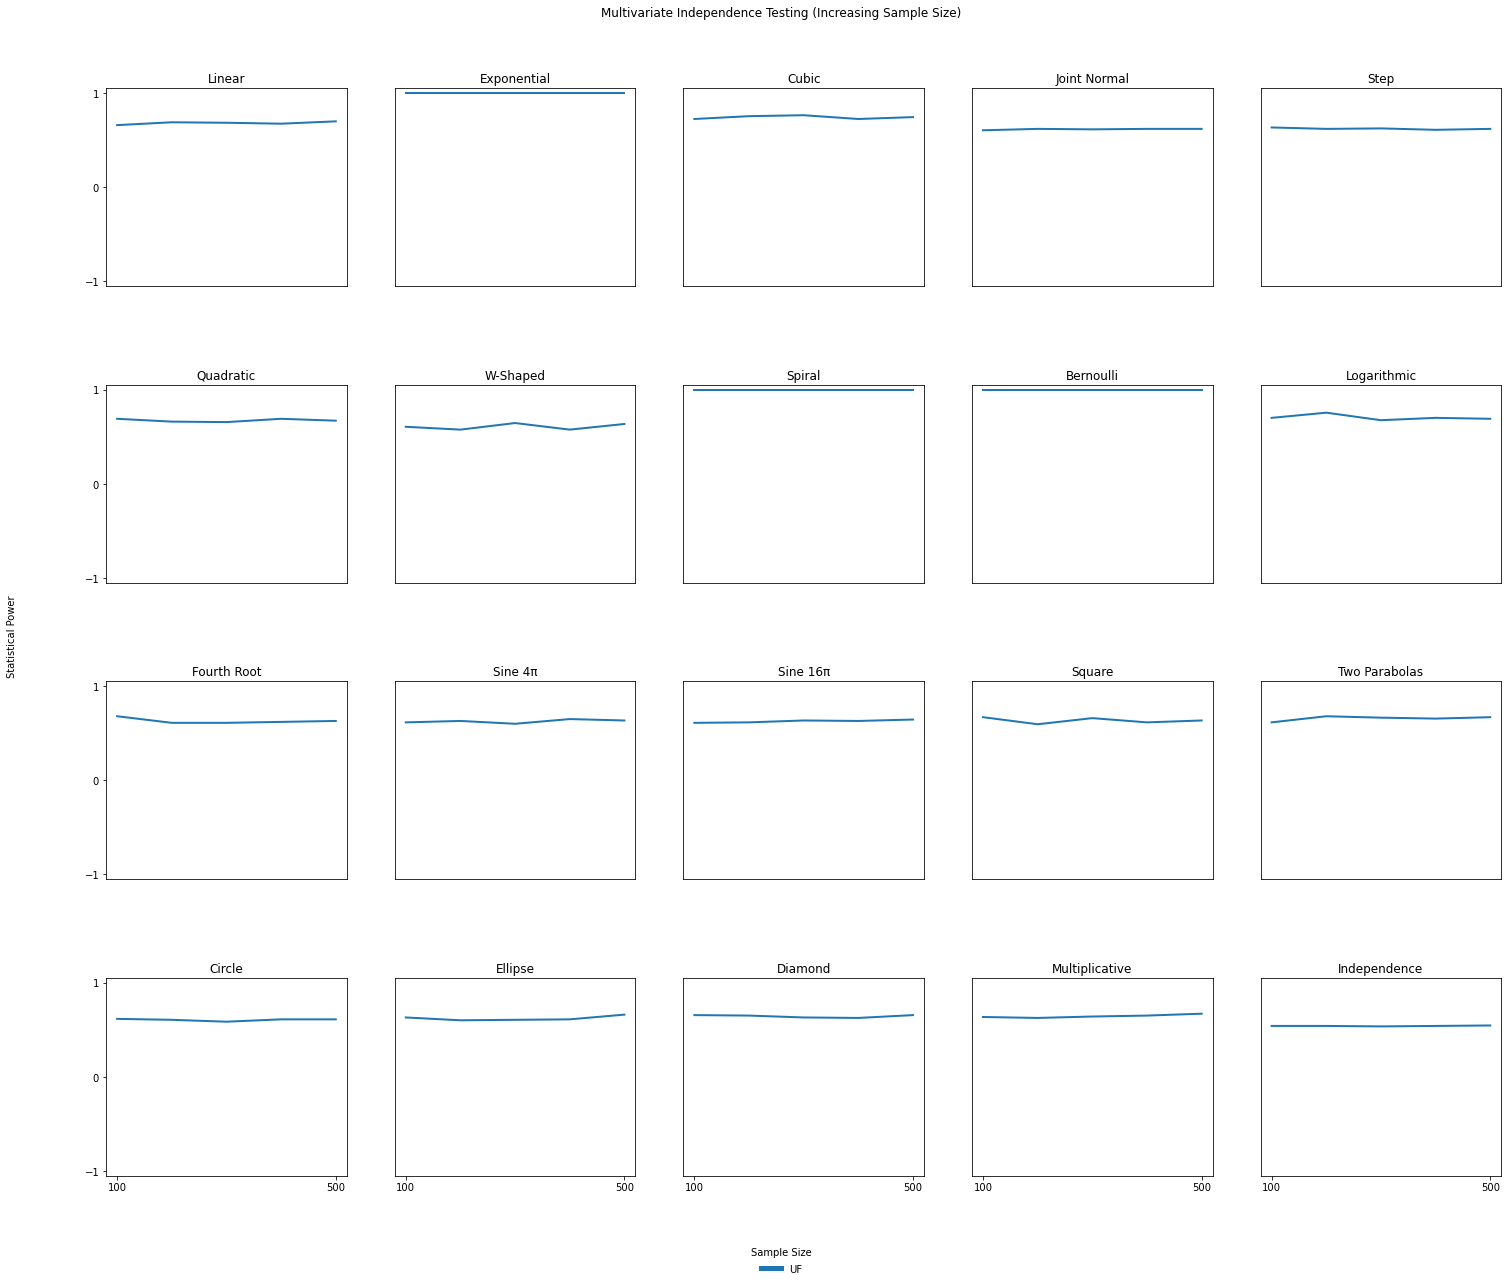

In [17]:
plot_power()